# Crypto of the Future #

<h4>Created by Ariel Lee, Rahul Razdan, and Gaurav Koley <br> </h4>

### Load required libraries

In [1]:
# preprocessing data
import pandas as pd
import json
import requests
import ssl
from datetime import datetime, timezone
import time
# import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping
import math
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

import numpy as np

#import torch
#import torch.nn as nn
#import torch.nn.functional as F
#import torch.optim as optim
#from torch.utils.data import Dataset
#from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

print("All libraries loaded")

All libraries loaded


### Download data using Binance API

In [2]:
# this code block was curated from cryptodatadownload and binance to use binance API
# download historical hourly data

# change the ssl state so we do not see an error for https:// content
ssl._create_default_https_context = ssl._create_unverified_context

def getUnixTimestamp(dateString, timespec='milliseconds', pattern=None):
    """
    This function takes a specific date string and tries to turn a date pattern into a unix timestamp 
    """
    if pattern is None:
        pattern = "%Y-%m-%dT%H:%M:%S"

    try:
        unix = int(time.mktime(time.strptime(dateString, pattern)))
    except ValueError as ve:
        iso_str = dateString.astimezone(timezone.utc).isoformat('T', timespec)
        unix = iso_str.replace('+00:00', 'Z')

    return unix


def OHLC_binance(pair, starttime, endtime, interval):
    """Function to read through OHLC historical timeseries 
    Accepts Binance Pair name using slash - 'ETH/USDT'
    starttime = a timestamp in this format "%Y-%m-%dT%H:%M:%S" 
    endtime = a timestamp in this format "%Y-%m-%dT%H:%M:%S"  
    interval = 1 Day (1d), 1 Hour (1h), 1 Minute (1m)
    """
    # create unix timestamps out of the date passed for Binance
    endTimeUnix = str(getUnixTimestamp(endtime)) + '000'   
    startTime = str(getUnixTimestamp(starttime)) + '000'  

    df_list = []   

    # split the slash (/) out of the symbol 'ETH/USDT' and create ETHUSDT instead
    sym = pair.split('/')    
    symbol = sym[0] + sym[1]

    while True:
        url = f"https://api.binance.com/api/v1/klines?symbol={symbol}&interval={interval}&limit=1000&startTime={startTime}&endTime={endTimeUnix}"  
        # get the request from Binance 
        response = requests.get(url)    

        # check if the response from Binance = 200 or "Good"
        if response.status_code == 200:   
            data = json.loads(response.text)  

            # take the json response and turn it into a pandas dataframe
            data_pd = pd.DataFrame(data, columns=['unix', 'open', 'high', 'low', 
                                                  'close', 'volume', 'close_unix', 'volume_from', 'tradecount', 
                                                  'marketorder_volume', 'marketorder_volume_from', 'misc'])
            # convert date out of unix timestamps
            data_pd['date'] = pd.to_datetime(data_pd['unix'], unit='ms')
            
            # drop misc column
            data_pd.drop(columns=['misc'], inplace=True)   
            data_pd['close'] = data_pd['close'].astype(str).astype(float)

            # append the dataframe candles to list that we are storing them in
            df_list.append(data_pd)  
            # check if len of json object is 0; if so, end loop
            if len(data_pd["unix"]) == 0:     
                break
            # reset the newest "startTime" to last date returned by previous API call
            startTime = str(data_pd['unix'].iloc[-1])  
            # since Binance returns 1000 candles, if its less than 500, end loop
            if len(data_pd["unix"]) < 500:         
                break 
        # bad server response
        else:    
            print(url)   
            print(response.status_code) 
            print(response.text)
            break

    master_df = pd.concat(df_list)  
    # drop any duplicate rows
    master_df = master_df.drop_duplicates(subset='unix', keep='first')   

    return master_df 

In [3]:
# can pull various time frames for testing
data_pd = OHLC_binance(pair='ETH/USDT', starttime='2017-08-17T00:00:00', 
                       endtime='2021-02-27T00:00:00', interval='1h')
data_pd.head()

# convert raw data to CSV file if needed
# filename = "ETH_Binance.csv"  
# data_pd.to_csv(filename, index=False) 

,unix,open,high,low,close,volume,close_unix,volume_from,tradecount,marketorder_volume,marketorder_volume_from,date
0,1502942400000,301.13000000,302.57000000,298.00000000,301.61,125.66877000,1502945999999,37684.80418100,129,80.56377000,24193.44078900,2017-08-17 04:00:00
1,1502946000000,301.61000000,303.28000000,300.00000000,303.10,377.67246000,1502949599999,114043.28267640,202,328.10428000,99079.80356860,2017-08-17 05:00:00
2,1502949600000,302.40000000,304.44000000,301.90000000,302.68,303.86672000,1502953199999,92034.44129390,182,259.28668000,78525.94861270,2017-08-17 06:00:00
3,1502953200000,302.68000000,307.96000000,302.60000000,307.96,754.74510000,1502956799999,229725.13696720,198,592.43176000,180297.96696090,2017-08-17 07:00:00
4,1502956800000,307.95000000,309.97000000,307.00000000,308.62,150.75029000,1502960399999,46559.46237070,182,140.68470000,43451.49539780,2017-08-17 08:00:00


### Data Preparation

In [4]:
# determine if any nan or infinity values need to be handled
data_pd.isin([np.nan, np.inf, -np.inf]).sum()

unix                       0
open                       0
high                       0
low                        0
close                      0
volume                     0
close_unix                 0
volume_from                0
tradecount                 0
marketorder_volume         0
marketorder_volume_from    0
date                       0
dtype: int64

In [5]:
# make date the first column for visualization
data_pd = data_pd.set_index(['date'])
data_pd.reset_index(inplace=True)
data_pd.head()

,date,unix,open,high,low,close,volume,close_unix,volume_from,tradecount,marketorder_volume,marketorder_volume_from
0,2017-08-17 04:00:00,1502942400000,301.13000000,302.57000000,298.00000000,301.61,125.66877000,1502945999999,37684.80418100,129,80.56377000,24193.44078900
1,2017-08-17 05:00:00,1502946000000,301.61000000,303.28000000,300.00000000,303.10,377.67246000,1502949599999,114043.28267640,202,328.10428000,99079.80356860
2,2017-08-17 06:00:00,1502949600000,302.40000000,304.44000000,301.90000000,302.68,303.86672000,1502953199999,92034.44129390,182,259.28668000,78525.94861270
3,2017-08-17 07:00:00,1502953200000,302.68000000,307.96000000,302.60000000,307.96,754.74510000,1502956799999,229725.13696720,198,592.43176000,180297.96696090
4,2017-08-17 08:00:00,1502956800000,307.95000000,309.97000000,307.00000000,308.62,150.75029000,1502960399999,46559.46237070,182,140.68470000,43451.49539780


In [6]:
# get rid of unnecessary features
data = data_pd.drop(axis=1, labels=['unix', 'close_unix', 'volume_from', 'marketorder_volume', 
                                     'marketorder_volume_from', 'open', 'low', 'high', 'tradecount', 'volume'])

data.head()

,date,close
0,2017-08-17 04:00:00,301.61
1,2017-08-17 05:00:00,303.10
2,2017-08-17 06:00:00,302.68
3,2017-08-17 07:00:00,307.96
4,2017-08-17 08:00:00,308.62


In [7]:
# Differencing actually yielded worse results so we took it out

# use difference method to remove seasonality
# assumes interval of 1 (subtracting adjacent rows)
# data['differenced'] = data['close'].diff().values
# data.head()

# make sure there are no null values after differencing
# data['differenced_checked'] = np.where(pd.isnull(data['differenced']), data['close'], data['differenced'])
# check to make sure differencing is correct
# data['reverse_difference'] = data['differenced_checked'].cumsum()

# reverse difference method for predictions
# def reverse_difference(prev_value, predictions):
#    rev_diff = [prev_value + predictions[0]]
#    for i in range(1, len(predictions)):
#        diff = rev_diff[i - 1] + predictions[i]
#        rev_diff.append(diff)
        
#    return rev_diff

# Dickey-Fuller test to make sure data is stationary

# p_test = adfuller(data['differenced_checked'])
# print('Dickey–Fuller test: %f' % p_test[0])
# print('p-value: %f' % p_test[1])

# if p_test[1] < 0.05:
#    print('Stationary data!')

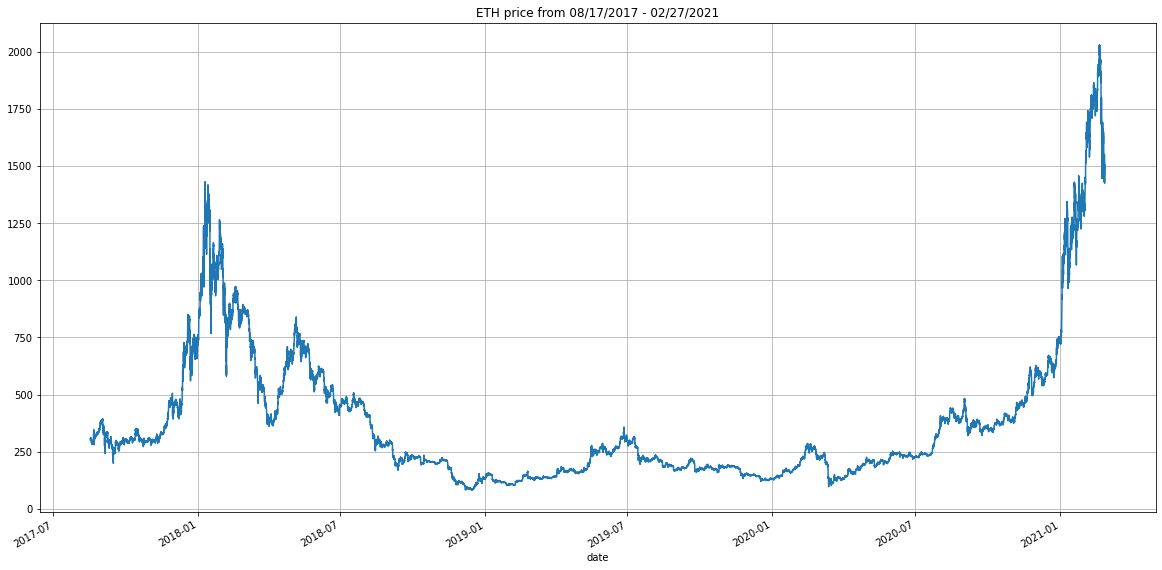

In [8]:
%matplotlib inline
FIGURE_SIZE = (20, 10)
plt.rcParams['axes.grid'] = True
%matplotlib inline

data.set_index('date')['close'].plot(figsize=FIGURE_SIZE)
# change as needed! 
plt.title('ETH price from 08/17/2017 - 02/27/2021')
plt.show()

In [9]:
# data['close_norm'] = scaler.fit_transform(np.array(data['close']).reshape(-1, 1))
# train_close = data['close_norm'][0]
# test_close = data['close_norm'][val_end]

# drop first row with nan values but keep the initial closing price for reverse differencing
# data = data.iloc[1:, :]

# default feature_range=(0, 1)
# scaler = MinMaxScaler()
# scaled_data = scaler.fit_transform(data[['high', 'low', 'volume', 'tradecount']])

# scaler_y = MinMaxScaler()
# scaled_data_y = scaler_y.fit_transform(data[['differenced']])

# X_train, X_test, y_train, y_test = train_test_split(scaled_data, scaled_data_y, 
#                                                    test_size=0.3, random_state=42, shuffle=False)

### Create datasets for input into LSTM

In [10]:
y = data['close']

training_size = int(len(y) * 0.7)
val_end = int(len(y) * 0.8)

# normalize
scaler = MinMaxScaler(feature_range=(0, 1))
y = scaler.fit_transform(np.array(y).reshape(-1, 1))

train_data, val_data, test_data = y[0:training_size, :], y[training_size:val_end, :],  y[val_end:len(y), :]

def create_dataset(dataset, time_step):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]    
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

In [11]:
time_step = 10

X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [12]:
# reshape for input into LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

### Build LSTM

In [13]:
model = Sequential()

# first LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(10, 1), activation='relu'))
model.add(Dropout(0.2))

# second LSTM layer
model.add(LSTM(units=50, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))

# third LSTM layer
model.add(LSTM(units=50, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))

# fourth LSTM layer
model.add(LSTM(units=50, activation='relu'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(units=1, activation='linear'))

# lr_schedule = ExponentialDecay(
#    0.001,decay_steps=100000,
#    decay_rate=0.96,
#    staircase=True)

# opt = Adam(learning_rate=lr_schedule)

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 10, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 10, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

### Train!

In [14]:
# use early stopping
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=23, 
                        verbose=1, mode='auto', restore_best_weights=False)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), verbose=1, epochs=300, callbacks=[monitor])

Epoch 1/300
675/675 [==============================] - 31s 41ms/step - loss: 0.0015 - val_loss: 4.8051e-05
Epoch 2/300
675/675 [==============================] - 27s 40ms/step - loss: 4.8389e-04 - val_loss: 6.1712e-05
Epoch 3/300
675/675 [==============================] - 27s 40ms/step - loss: 4.2321e-04 - val_loss: 2.9870e-05
Epoch 4/300
675/675 [==============================] - 28s 41ms/step - loss: 3.5541e-04 - val_loss: 1.5782e-04
Epoch 5/300
675/675 [==============================] - 28s 41ms/step - loss: 3.6980e-04 - val_loss: 6.1929e-05
Epoch 6/300
675/675 [==============================] - 29s 42ms/step - loss: 3.2878e-04 - val_loss: 6.3085e-05
Epoch 7/300
675/675 [==============================] - 28s 41ms/step - loss: 3.1410e-04 - val_loss: 4.5675e-05
Epoch 8/300
675/675 [==============================] - 28s 41ms/step - loss: 3.1674e-04 - val_loss: 1.5325e-04
Epoch 9/300
675/675 [==============================] - 28s 41ms/step - loss: 3.1941e-04 - val_loss: 9.8463e-05
Epoch

### Predictions and visualization

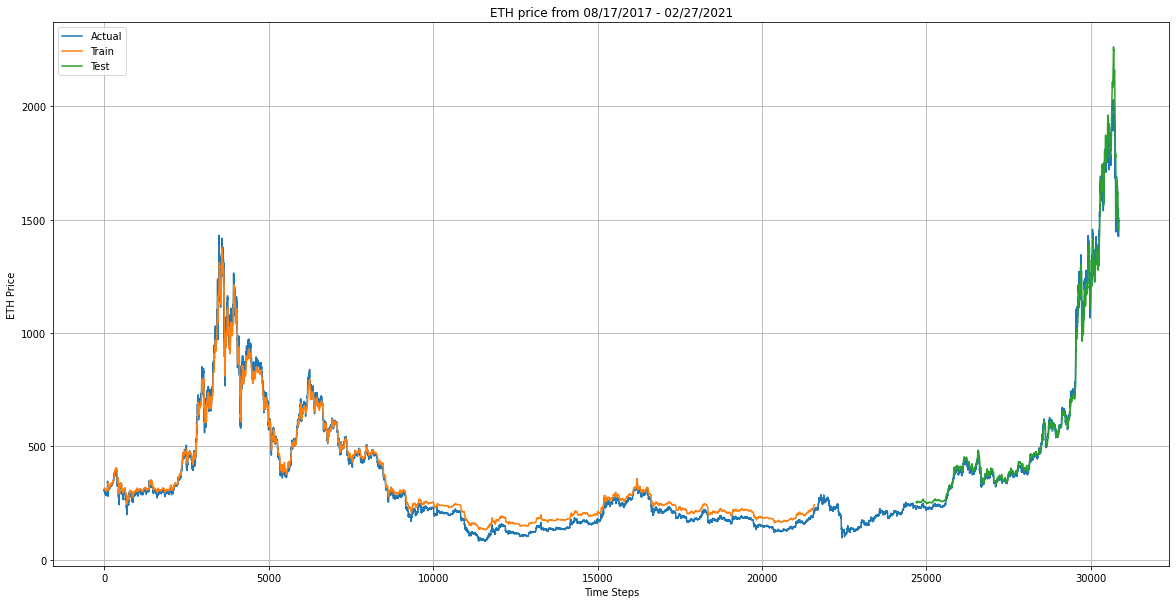

In [15]:
# predictions 
train_predict = model.predict(X_train)
tpredict = model.predict(X_test)

# undo MinMax normalization
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(tpredict)

# reverse differencing 
# train_predict = reverse_difference(train_close, train_predict)
# test_predict = reverse_difference(test_close, tpredict)

# plotting for visualization
# shift train predictions 
fig, ax = plt.subplots(figsize=(20, 10))
train_plot = np.empty_like(y)
train_plot[:, :] = np.nan
train_plot[time_step:len(train_predict) + time_step, :] = train_predict

# shift test predictions 
test_plot = np.empty_like(y)
test_plot[:, :] = np.nan
test_plot[val_end + (time_step) + 1:len(y), :] = test_predict

# plot baseline + predictions
plt.plot(data['close'])
plt.plot(train_plot)
plt.plot(test_plot)
plt.legend(['Actual', 'Train', 'Test'])
plt.xlabel('Time Steps')
plt.ylabel('ETH Price')
plt.title('ETH price from 08/17/2017 - 02/27/2021') 
plt.show()

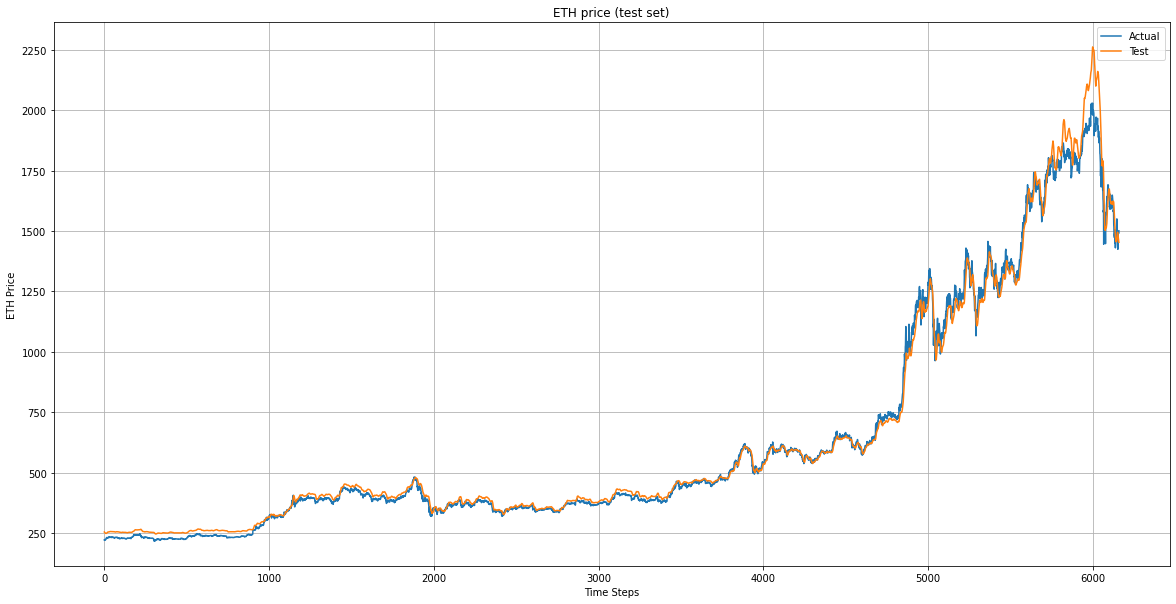

In [16]:
# test set only plot of easier visualization
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)))
plt.plot(test_predict)
plt.legend(['Actual', 'Test'])
plt.xlabel('Time Steps')
plt.ylabel('ETH Price')
plt.title('ETH price (test set)')
plt.show()

### Mean squared error

In [17]:
print('the mean squared error is: ', mean_squared_error(tpredict, y_test))

the mean squared error is:  0.00038549826382444966


### Loss plot

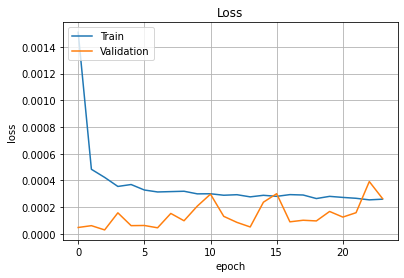

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()